## Why the Digital Option Example Exposes MLMC’s “Blind-Sampling” Failure

1. **Payoff Discontinuity → Poor Coupling**  
   Define the level-ℓ increment as  
   $$
   \Delta P_\ell \;=\; P_\ell - P_{\ell-1}\,.
   $$  
   For a digital payoff  
   $$
   P(S_T)=\mathbf{1}_{\{S_T>K\}},
   $$  
   almost every fine/coarse pair produces the same 0 → 0 or 1 → 1, until a rare path crosses the strike. Hence  $\Delta P_\ell$ is almost always zero, and its variance is tiny except on boundary paths.

2. **Flat & Clamped Pilot Variance Estimates**  
   In the pilot phase we draw \(N_0=1024\) coupled samples at each level and compute the **sample variance** of the single‐path increments:
   $$
   V_\ell
   \;\approx\;
   \mathrm{Var}\bigl[\Delta P_\ell\bigr]
   \;
   $$
   Because  $\Delta P_\ell $ is nearly always zero, we get  $\;V_0\approx V_1\approx V_2\; $,  a flat, uninformative profile.

3. **Blind Allocation Sees No Signal**  
   The MLMC allocation rule  
   $$
   N_\ell \;\propto\;\sqrt{\frac{V_\ell}{C_\ell}}
   $$
   then “sees” almost identical  $V_\ell $ at every level and, despite the fact that cost  $C_\ell $ grows like  $2^\ell $, ends up assigning roughly the same  $N_\ell $ everywhere.

4. **Wasted Computation on Coarse Levels**  
   Coarse levels ( $\ell $ small) are cheap per sample but contribute virtually **no information** (since  $\Delta P_\ell\approx 0 $ almost always). Standard MLMC still invests thousands of samples there, purely based on its blind variance–cost ratio.

   Simply refining levels makes non-zero corrections even rarer ( $\Pr(\Delta P_\ell\neq0)=O(\sqrt{h_\ell})$), so MLMC wastes costly fine‐level samples on zeros. You need smoothing or targeted stratification to catch the rare boundary crossings.
5. **Where AI/ML Can Help**  
   This failure mode pinpoints exactly **why** and **where** to intervene with learning:  
   - **Detect** the rare “boundary” paths that produce nonzero  $\Delta P_\ell $.  
   - **Cluster** or score those paths by their feature‐based impact.  
   - **Reallocate** sampling effort away from the mass of zero‐difference paths toward the few that matter.


In [49]:
import sys, os, time, math
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import norm

# --- local package ------------------------------------------------------------
sys.path.append(os.path.abspath('..'))
from mlmc import MLMC,  C_MLMC, WeakConvergenceError
from mlmc.bs_level_terminal import MilsteinBSLevelFunction
from mlmc.payoffs import digital_payoff

In [50]:
# parameters
S0, K = 80.0, 100.0
r, sigma  = 0.05, 0.1
T     = 1.0

# Target tolerances for demonstration
EPS = [0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125]

In [51]:
def bs_exact_digital_call(S0, K, r, sigma, T):
    """Exact price of a digital call option in the Black-Scholes model."""
    d2 = (math.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 -= sigma * math.sqrt(T)
    price = math.exp(-r * T) * norm.cdf(d2)
    return price

exact= bs_exact_digital_call(S0, K, r, sigma, T)

# MLMC

In [52]:
# MLMC setup
payoff   = lambda S: digital_payoff(S, K)

level_fn = MilsteinBSLevelFunction(S0, r, sigma, T, payoff,verbose=False).simulate

mlmc_obj = MLMC(level_fn, Lmin=2, Lmax=20, N0=5000)

In [53]:
# Run standard MLMC 
records = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = mlmc_obj.estimate(eps)
        rec.update({
            "price": price,
            "time_s": time.perf_counter() - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy()
        })
    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err)
        })
    records.append(rec)


[Bias Check] L=2, extrapolated remainder=1.5585e-01, threshold=1.0000e-01
[Bias Check] L=3, extrapolated remainder=2.0447e-02, threshold=1.0000e-01
[Bias Check] L=2, extrapolated remainder=1.1761e-01, threshold=5.0000e-02
[Bias Check] L=3, extrapolated remainder=1.5360e-02, threshold=5.0000e-02
[Bias Check] L=2, extrapolated remainder=1.1186e-01, threshold=2.5000e-02
[Bias Check] L=3, extrapolated remainder=9.3557e-03, threshold=2.5000e-02
[Bias Check] L=2, extrapolated remainder=2.5395e-01, threshold=1.2500e-02
[Bias Check] L=3, extrapolated remainder=1.2348e-02, threshold=1.2500e-02
[Bias Check] L=2, extrapolated remainder=1.0652e-01, threshold=6.2500e-03
[Bias Check] L=3, extrapolated remainder=2.8105e-02, threshold=6.2500e-03
[Bias Check] L=4, extrapolated remainder=9.9045e-03, threshold=6.2500e-03
[Bias Check] L=5, extrapolated remainder=3.4796e-02, threshold=6.2500e-03
[Bias Check] L=6, extrapolated remainder=1.9218e-03, threshold=6.2500e-03
[Bias Check] L=2, extrapolated remaind

In [54]:
# exact price
print(f"Exact price: {exact}")

# results
df = pd.DataFrame(records)

Nl_df = pd.DataFrame(df["N_per_level"].tolist(), index=df.index).add_prefix("N_l_")
out = pd.concat([df.drop(columns="N_per_level"), Nl_df], axis=1)
out = out.fillna(0)
display(out)


Exact price: 0.02849536146532932


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2,N_l_3,N_l_4,N_l_5,N_l_6,N_l_7,N_l_8
0,0.200000,0.038620,0.003235,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
1,0.100000,0.035766,0.001572,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
2,0.050000,0.032152,0.001378,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
3,0.025000,0.032152,0.001393,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
4,0.012500,0.033864,0.009858,635000.0,5000,5000,5000,5000,5000.0,5000.0,5000.0,0.0,0.0
5,0.006250,0.038239,0.035846,2555000.0,5000,5000,5000,5000,5000.0,5000.0,5000.0,5000.0,5000.0
6,0.003125,0.035329,0.029813,2568613.0,18613,5000,5000,5000,5000.0,5000.0,5000.0,5000.0,5000.0


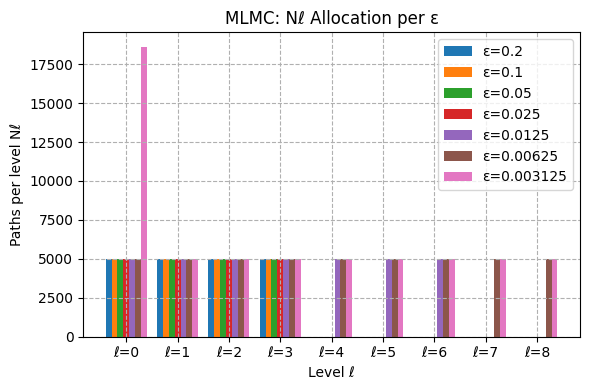

In [55]:
level_cols = [col for col in out.columns if col.startswith("N_l_")]
levels = np.arange(len(level_cols))
bar_width = 0.8 / len(out)

fig, ax = plt.subplots(figsize=(6, 4))

for i, (_, row) in enumerate(out.iterrows()):
    Nl = row[level_cols].values
    ax.bar(levels + i * bar_width, Nl, width=bar_width, label=f"ε={row['epsilon']}")

ax.set_xticks(levels + bar_width * (len(out) - 1) / 2)
ax.set_xticklabels([col.replace("N_l_", "ℓ=") for col in level_cols])
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nℓ")
ax.set_title("MLMC: Nℓ Allocation per ε")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [56]:
# Inspect Yₗ for levels 0 and 1 to compare payoff variance vs. increment variance
N_test = 100_000

for l_test in [0, 1, 2, 3, 4 ,5]:
    # simulate N_test coupled samples at level l_test
    sums, cost = mlmc_obj._f(l_test, N_test)
    sumY, sumY2 = sums

    # empirical mean and variance of Yₗ
    meanY = sumY  / N_test
    varY  = sumY2 / N_test - meanY**2

    print(f"Level {l_test}: mean(Y_{l_test}) = {meanY:.3e}, var(Y_{l_test}) = {varY:.3e}")


Level 0: mean(Y_0) = 2.809e-02, var(Y_0) = 2.593e-02
Level 1: mean(Y_1) = 2.797e-03, var(Y_1) = 2.652e-03
Level 2: mean(Y_2) = 1.655e-03, var(Y_2) = 1.572e-03
Level 3: mean(Y_3) = 8.371e-04, var(Y_3) = 7.956e-04
Level 4: mean(Y_4) = 4.090e-04, var(Y_4) = 3.889e-04
Level 5: mean(Y_5) = 2.283e-04, var(Y_5) = 2.171e-04


# C-MLMC

In [57]:
# feature extractor for C_MLMC
def feature_fn(detail):
    S_f = detail["S_fine"]
    S_c = detail.get("S_coarse", S_f)
    
    return abs(S_f - K)

cmlmc_obj  = C_MLMC(level_fn, feature_fn, Lmin=2, Lmax=20, n_clusters=3, N0=5000, scale_features=True)


In [58]:
# Run C-MLMC
records2 = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = cmlmc_obj.estimate(eps)
        rec.update({
            "price": price,
            "time_s": time.perf_counter() - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy()
        })
    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err)
        })
    records2.append(rec)


In [59]:
# exact price
print(f"Exact price: {exact}")

# results
df2 = pd.DataFrame(records2)

Nl_df2 = pd.DataFrame(df2["N_per_level"].tolist(), index=df2.index).add_prefix("N_l_")
out2 = pd.concat([df2.drop(columns="N_per_level"), Nl_df2], axis=1)
out2 = out2.fillna(0)
display(out2)

Exact price: 0.02849536146532932


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2
0,0.200000,0.035195,0.029714,35000.0,5000,5000,5000
1,0.100000,0.032722,0.029680,35000.0,5000,5000,5000
2,0.050000,0.028537,0.027643,35000.0,5000,5000,5000
3,0.025000,0.033864,0.025852,35000.0,5000,5000,5000
4,0.012500,0.034815,0.022042,35000.0,5000,5000,5000
5,0.006250,0.027776,0.023620,35000.0,5000,5000,5000
6,0.003125,0.035576,0.024210,35000.0,5000,5000,5000


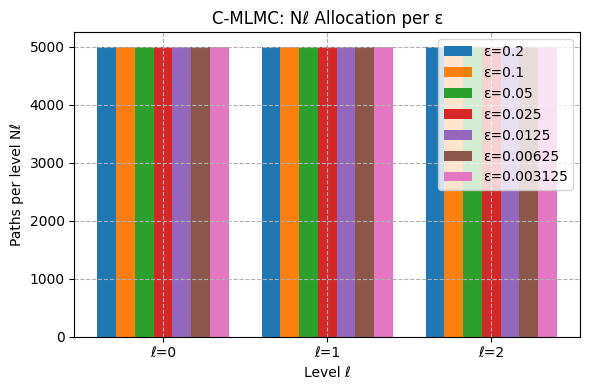

In [60]:
level_cols = [col for col in out2.columns if col.startswith("N_l_")]
levels = np.arange(len(level_cols))
bar_width = 0.8 / len(out2)

fig, ax = plt.subplots(figsize=(6, 4))

for i, (_, row) in enumerate(out2.iterrows()):
    Nl = row[level_cols].values
    ax.bar(levels + i * bar_width, Nl, width=bar_width, label=f"ε={row['epsilon']}")

ax.set_xticks(levels + bar_width * (len(out2) - 1) / 2)
ax.set_xticklabels([col.replace("N_l_", "ℓ=") for col in level_cols])
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nℓ")
ax.set_title("C-MLMC: Nℓ Allocation per ε")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [61]:
out

,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2,N_l_3,N_l_4,N_l_5,N_l_6,N_l_7,N_l_8
0,0.200000,0.038620,0.003235,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
1,0.100000,0.035766,0.001572,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
2,0.050000,0.032152,0.001378,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
3,0.025000,0.032152,0.001393,75000.0,5000,5000,5000,5000,0.0,0.0,0.0,0.0,0.0
4,0.012500,0.033864,0.009858,635000.0,5000,5000,5000,5000,5000.0,5000.0,5000.0,0.0,0.0
5,0.006250,0.038239,0.035846,2555000.0,5000,5000,5000,5000,5000.0,5000.0,5000.0,5000.0,5000.0
6,0.003125,0.035329,0.029813,2568613.0,18613,5000,5000,5000,5000.0,5000.0,5000.0,5000.0,5000.0


In [62]:
out2

,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2
0,0.200000,0.035195,0.029714,35000.0,5000,5000,5000
1,0.100000,0.032722,0.029680,35000.0,5000,5000,5000
2,0.050000,0.028537,0.027643,35000.0,5000,5000,5000
3,0.025000,0.033864,0.025852,35000.0,5000,5000,5000
4,0.012500,0.034815,0.022042,35000.0,5000,5000,5000
5,0.006250,0.027776,0.023620,35000.0,5000,5000,5000
6,0.003125,0.035576,0.024210,35000.0,5000,5000,5000


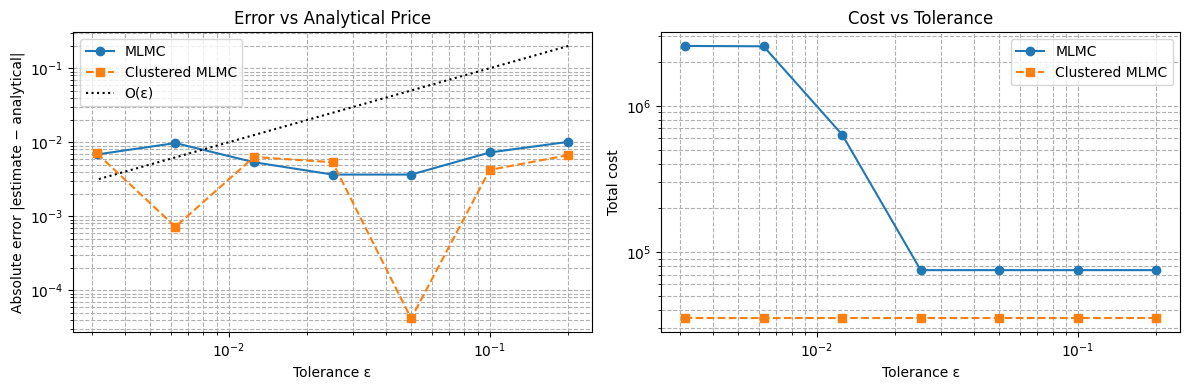

In [63]:
tols      = out["epsilon"].values
errors_ml = abs(out["price"] - exact)
errors_cl = abs(out2["price"] - exact)
costs_ml  = out["total_cost"].values
costs_cl  = out2["total_cost"].values

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Error vs Analytical
axs[0].loglog(tols, errors_ml, 'o-', label='MLMC')
axs[0].loglog(tols, errors_cl, 's--', label='Clustered MLMC')
axs[0].loglog(tols, tols, 'k:', label='O(ε)')
axs[0].set_xlabel("Tolerance ε")
axs[0].set_ylabel("Absolute error |estimate − analytical|")
axs[0].set_title("Error vs Analytical Price")
axs[0].legend()
axs[0].grid(True, which="both", ls="--")

# Cost vs Tolerance
axs[1].loglog(tols, costs_ml, 'o-', label='MLMC')
axs[1].loglog(tols, costs_cl, 's--', label='Clustered MLMC')
axs[1].set_xlabel("Tolerance ε")
axs[1].set_ylabel("Total cost")
axs[1].set_title("Cost vs Tolerance")
axs[1].legend()
axs[1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

In [64]:
info = cmlmc_obj.get_cluster_info(level=2)
print("Cluster centers:\n", info["centers"])
print("Cluster probabilities:\n", info["probs"])
print("Cluster variances:\n", info["vars"])

Cluster centers:
 [[-1.17830282]
 [ 0.07605986]
 [ 1.26045228]]
Cluster probabilities:
 [0.304  0.4368 0.2592]
Cluster variances:
 [3.55996981e-03 1.00000000e-06 1.00000000e-06]


## Why Level 0 Dominates in the Digital Option Example

**Large time step ⇒ high jump probability**  
   At level 0, we use a single Euler step of size $h = T$, so the terminal price is  
   $$  
   S_T^{(h)} = S_0 \exp\bigl((r - \tfrac12\sigma^2)T + \sigma\sqrt{T}\,Z\bigr).  
   $$  
   Whether $S_T^{(h)} > K$ is then a Bernoulli event with variance $p(1 - p) \approx 0.25$, giving $Y_0 = P_0$ high variance.

